<a href="https://colab.research.google.com/github/prayas99/CNN-based-defect-detection-model/blob/main/CNN_based_defect_detection_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Enter dataset path

In [ ]:
path_to_dataset = 'path_to_dataset'

# Model

In [ ]:
# path_to_dataset/ccnn_pytorch/main.py

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class CompactCNN(nn.Module):

    def __init__(self):
        super(CompactCNN, self).__init__()
        # 1 input image channel, 6 output channels, 5x5 square convolution
        # kernel
        self.conv1 = nn.Conv2d(1, 32, 11,stride=2,padding=5) #padding = k-1/2
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32,32, 11,padding=5)
        self.bn2 = nn.BatchNorm2d(32)
        self.conv3 = nn.Conv2d(32, 32, 11,padding=5)
        self.bn3 = nn.BatchNorm2d(32)
        
        self.conv4 = nn.Conv2d(32,64, 7,stride=2,padding=3)
        self.bn4 = nn.BatchNorm2d(64)
        self.conv5 = nn.Conv2d(64,64, 7,padding=3)
        self.bn5 = nn.BatchNorm2d(64)
        self.conv6 = nn.Conv2d(64,64, 7,padding=3)
        self.bn6 = nn.BatchNorm2d(64)
        
        self.conv7 = nn.Conv2d(64, 128, 3,padding=1)
        self.bn7 = nn.BatchNorm2d(128)
        self.conv8 = nn.Conv2d(128, 128, 3,padding=1)
        self.bn8 = nn.BatchNorm2d(128)
        self.conv9 = nn.Conv2d(128, 128, 3,padding=1)
        self.bn9 = nn.BatchNorm2d(128)
        
        self.conv10 = nn.Conv2d(128,1,1)
        self.bn10 = nn.BatchNorm2d(1)
        
        self.complayer = nn.Conv2d(128,32,1)
        self.bn11 = nn.BatchNorm2d(32)
        
        self.gmaxp = nn.MaxPool2d(128)
        self.gavgp = nn.AvgPool2d(128)
        
        self.sneuron = nn.Conv2d(66,1,1)

    def forward(self, x):
        # Max pooling over a (2, 2) window
        x = self.bn1(F.relu(self.conv1(x))) 
        x = self.bn2(F.relu(self.conv2(x))) 
        x = self.bn3(F.relu(self.conv3(x))) 

        x = self.bn4(F.relu(self.conv4(x))) 
        x = self.bn5(F.relu(self.conv5(x))) 
        x = self.bn6(F.relu(self.conv6(x))) 
        
        x = self.bn7(F.relu(self.conv7(x))) 
        x = self.bn8(F.relu(self.conv8(x))) 
        x = self.bn9(F.relu(self.conv9(x))) 
        
        segout = self.bn10(torch.tanh(self.conv10(x)))
        
        complayer = self.bn11(self.complayer(x))
        max1 = self.gmaxp(complayer)
        avg1 = self.gavgp(complayer)
        max0 = self.gmaxp(segout)
        avg0 = self.gavgp(segout)
#         print(max0.shape,avg0.shape,max1.shape,avg1.shape)
        x = torch.cat((max0,avg0,max1,avg1),dim=1)
        cscore = torch.sigmoid(self.sneuron(x))
        return segout,cscore

In [ ]:
import time,copy
from tqdm import tqdm
import torch

def train_seg_model(model, criterion, optimizer,dataloaders,device,num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss = 1e10

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['Train', 'Test']:
            if phase == 'Train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            # Iterate over data.
            for sample in tqdm(iter(dataloaders[phase])):
                inputs = sample['image'].to(device)
                masks = sample['mask'].to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'Train'):
                    outputs,_ = model(inputs)
                    loss = criterion(outputs, masks)

                    # backward + optimize only if in training phase
                    if phase == 'Train':
                        loss.backward()
                        optimizer.step()

            epoch_loss =loss

            print('{} Loss: {:.4f}'.format(
                phase, loss))

            # deep copy the model
            if phase == 'Test' and loss < best_loss:
                best_loss = loss
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Lowest Loss: {:4f}'.format(best_loss))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

def train_class_model(model, criterion, optimizer,dataloaders,device,num_epochs=10):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss = 1e10

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['Train', 'Test']:
            if phase == 'Train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            # Iterate over data.
            for img,lab in tqdm(iter(dataloaders[phase])):
                img = img.to(device)
                lab = lab.type(torch.float32)
                lab = lab.to(device)
                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'Train'):
                    _,outputs = model(img)
                    loss = criterion(outputs.flatten(), lab)

                    # backward + optimize only if in training phase
                    if phase == 'Train':
                        loss.backward()
                        optimizer.step()

            epoch_loss =loss

            print('{} Loss: {:.4f}'.format(
                phase, loss))

            # deep copy the model
            if phase == 'Test' and loss < best_loss:
                best_loss = loss
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Lowest Loss: {:4f}'.format(best_loss))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [ ]:
import torch
from skimage import io, transform
from torch.utils.data import Dataset, DataLoader
from torchvision.datasets import ImageFolder
from torchvision import transforms, utils,datasets
import os,glob,cv2

class DAGMDataset(Dataset):
    """DAGM Dataset"""

    def __init__(self,root_dir, transform=None):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
         
         on a sample.
        """
        self.root_dir = root_dir
        self.transform = transform
        self.image_names = sorted(glob.glob(os.path.join(self.root_dir,'Image','*.PNG')))
        self.mask_names = sorted(glob.glob(os.path.join(self.root_dir,'Label','*.PNG')))

    def __len__(self):
        return len(self.image_names)

    def __getitem__(self, idx):
        img_name = self.image_names[idx]
        image = io.imread(img_name)
        
        msk_name = self.mask_names[idx]
        mask = io.imread(msk_name)
        sample = {'image': image, 'mask': mask}

        if self.transform:
            sample = self.transform(sample)

        return sample


class ToTensor(object):
    """Convert ndarrays in sample to Tensors."""

    def __call__(self, sample):
        image, mask = sample['image'], sample['mask']
        image = image.reshape((1,)+image.shape)
        mask = cv2.resize(mask,(128,128),cv2.INTER_AREA)
        mask = mask.reshape((1,)+mask.shape)
        return {'image': torch.from_numpy(image),
                'mask': torch.from_numpy(mask)}


class Normalize(object):
    #Normalize image
    def __call__(self,sample):
        image, mask = sample['image'], sample['mask']
        return {'image': image.type(torch.FloatTensor)/255,
                'mask': mask.type(torch.FloatTensor)/255}



def segmentation_dataset(data_dir = '../Class8/'):
    #Returns the dataset for segmentation
    data_transforms = {
        'Train': transforms.Compose([ToTensor(),Normalize()]),
        'Test': transforms.Compose([ToTensor(),Normalize()]),
    }

    image_datasets = {x: DAGMDataset(os.path.join(data_dir, x),
                                              data_transforms[x])
                      for x in ['Train', 'Test']}
    dataloaders = {x: DataLoader(image_datasets[x], batch_size=32,
                                                 shuffle=True, num_workers=8)
                  for x in ['Train', 'Test']}
    dataset_sizes = {x: len(image_datasets[x]) for x in ['Train', 'Test']}
    return dataloaders

# Just normalization for validation

def classification_dataset(data_dir = '../Class8/Classification/'):
    # Returns the dataloaders for classification as well the class to class index dictionary.
    data_transforms = {
        'Train': transforms.Compose([transforms.functional.to_grayscale,transforms.ToTensor()]),
        'Test': transforms.Compose([transforms.Grayscale(),transforms.ToTensor()]),
    }

    class_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                              transform=data_transforms[x])
                      for x in ['Train', 'Test']}
    class_dataloaders = {x: DataLoader(class_datasets[x],batch_size=32,shuffle=True,num_workers=32) for x in ['Train', 'Test']}
    
    return class_dataloaders,class_datasets['Train'].class_to_idx,class_datasets['Test'].class_to_idx


In [ ]:
import os
import torch
import torch.nn

# Create the CompactCNN model
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = CompactCNN().to(device)

# Train for the segmentation 
criterion = torch.nn.MSELoss(reduction='mean')
optimizer = torch.optim.Adadelta(list(model.parameters())[:-6])
dataloaders=segmentation_dataset('path_to_dataset/Class8/')
trained_model = train_seg_model(model,criterion, optimizer,dataloaders,device,num_epochs=25)

if not os.path.isdir('./models'):
  os.mkdir('./models')
torch.save(trained_model.state_dict(),'./models/segmentationweights')

dataloaders,trainmap,testmap = classification_dataset()

# model.load_state_dict(torch.load('./models/segmentationweights'))
criterion = torch.nn.BCELoss()
optimizer = torch.optim.Adadelta(list(model.parameters())[-6:])
trained_model = train_class_model(model, criterion, optimizer,dataloaders,device,num_epochs=10)
torch.save({'classidx':trainmap,'model_state_dict':trained_model.state_dict()},'./models/compactcnnweights')

# Testing

Prediction labels: {'Defective': 0, 'NonDefective': 1}
Prediction probability: 4.516e-17


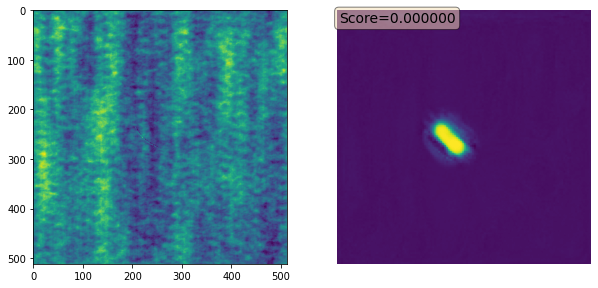

In [ ]:
import cv2
import matplotlib.pyplot as plt
import torch

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model = CompactCNN().to(device)
modeldata = torch.load('path_to_dataset/ccnn_pytorch/models/compactcnnweights')
model.load_state_dict(modeldata['model_state_dict'])
model.eval()


#0 means defective image and 1 means defect free image
print('Prediction labels:' ,modeldata['classidx'])
#Open an image and predict 
ino=62
img = cv2.imread(f'path_to_dataset/Class8/Test/Image/{ino:04d}.PNG',0).reshape(1,1,512,512)
#img = cv2.imread('/content/test6.JPG')[:512,:512,0].reshape(1,1,512,512)
a = model(torch.from_numpy(img).type(torch.cuda.FloatTensor)/255)
print(f'Prediction probability: {a[1].item():.3e}')
plt.figure(figsize=(10,10))
plt.subplot(121)
plt.imshow(img[0][0])
plt.subplot(122)
plt.imshow(a[0].cpu().detach().numpy()[0][0])
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
plt.text(0.2, 0.1, f'Score={a[1].item():03f}', fontsize=14,
        verticalalignment='top', bbox=props)
plt.axis('off')
plt.show()

In [ ]:
import numpy as np
img = cv2.imread(f'/content/test.JPG')[:,:,0]
np.shape(img)

(716, 1021)